In [1]:
import time
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [6]:
def plot_batch(img_batch,labels):
    fig = plt.figure(figsize=(20,5))
    for idx in range(len(img_batch)):
        ax = fig.add_subplot(2,len(img_batch)/2,idx+1,xticks=[],yticks=[])
        ax.imshow(img_batch[idx].numpy().squeeze(),cmap="gray")
        ax.set_title(f"Class: {labels[idx].item()}")

transform = transforms.ToTensor()

In [7]:
train_data = datasets.MNIST(root="./",train=True,transform=transform)
test_data = datasets.MNIST(root="./",train=False,transform=transform)

trainloader = DataLoader(train_data,batch_size=16,shuffle=True)
testloader = DataLoader(test_data,batch_size=16,shuffle=True)

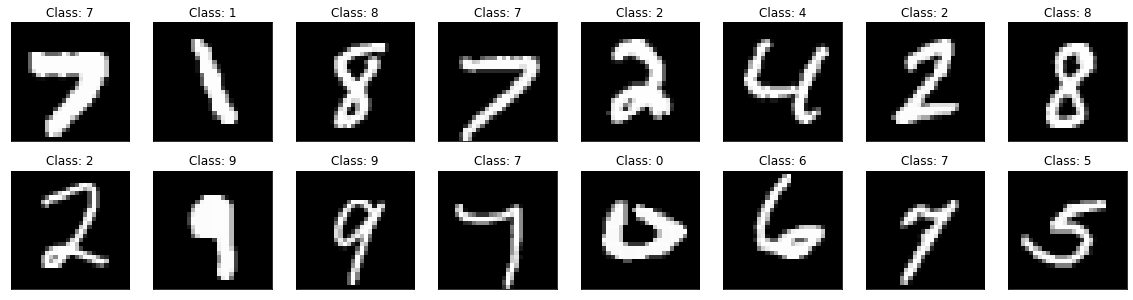

In [12]:
train_imgs,train_labels = next(iter(trainloader))
plot_batch(train_imgs,train_labels)

In [18]:
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser,self).__init__()
        
        # encoder layers
        self.conv_1 = nn.Conv2d(1,32,3,padding=1) # 14x14
        self.conv_2 = nn.Conv2d(32,16,3,padding=1) # 7x7
        self.conv_3 = nn.Conv2d(16,8,3,padding=1) # 3x3
        self.pool = nn.MaxPool2d(2,2)
        
        # decoder layers
        self.deconv_1 = nn.ConvTranspose2d(8,8,3,stride=2) # 7x7
        self.deconv_2 = nn.ConvTranspose2d(8,16,2,stride=2) # 14x14
        self.deconv_3 = nn.ConvTranspose2d(16,32,2,stride=2) # 28x28
        self.out = nn.Conv2d(32,1,3,padding=1) # 1x28x28
        
    def forward(self,x):
        x = F.relu(self.conv_1(x)) 
        x = self.pool(x)            
        x = F.relu(self.conv_2(x)) 
        x = self.pool(x)            
        x = F.relu(self.conv_3(x))
        x = self.pool(x)           
        x = F.relu(self.deconv_1(x))
        x = F.relu(self.deconv_2(x))
        x = F.relu(self.deconv_3(x))
        x = torch.sigmoid(self.out(x))
        return x
        
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv_1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (deconv_2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (deconv_3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [26]:
def train(model,trainloader,criterion,optimizer,epochs):
    train_losses = []
    for e in range(epochs):
        start = time.time()
        train_loss = 0
        for data in trainloader:
            images,_ = data
            noisy_imgs = images + 0.5 * torch.randn(*images.shape)
            noisy_imgs = np.clip(noisy_imgs,0.,1.)
            optimizer.zero_grad()
            outputs = model(noisy_imgs)
            loss = criterion(outputs,images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss/len(trainloader))
        print(f"epoch:{e+1}/{epochs} trainloss:{train_loss/len(trainloader):.5f} time:{time.time() - start:.3f}sec")
    return train_losses

In [27]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
train_loss = train(model,trainloader,criterion,optimizer,10)

epoch:1/10 trainloss:0.11205 time:106.191sec
epoch:2/10 trainloss:0.05877 time:103.925sec
epoch:3/10 trainloss:0.02543 time:109.235sec
epoch:4/10 trainloss:0.02455 time:100.706sec
epoch:5/10 trainloss:0.02417 time:101.520sec
epoch:6/10 trainloss:0.02384 time:109.005sec
epoch:7/10 trainloss:0.02362 time:100.116sec
epoch:8/10 trainloss:0.02346 time:119.138sec
epoch:9/10 trainloss:0.02323 time:92.163sec
epoch:10/10 trainloss:0.02288 time:92.699sec


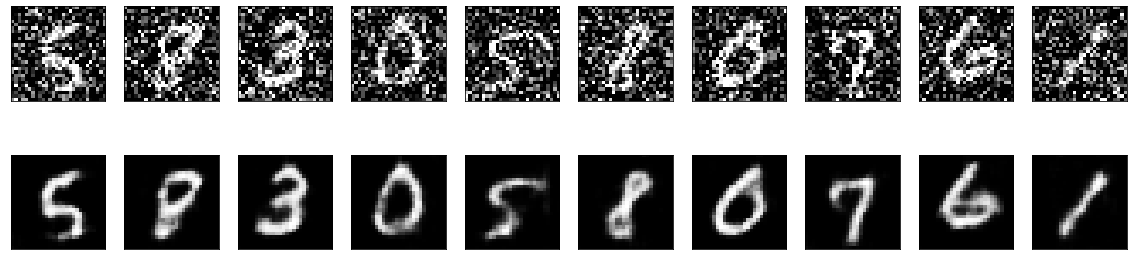

In [28]:
test_images, _ = next(iter(testloader))

noisy_imgs = test_images + 0.5 * torch.randn(*test_images.shape)
noisy_imgs = np.clip(noisy_imgs,0.,1.)

outputs = model(noisy_imgs)
outputs = outputs.view(outputs.shape[0],1,28,28)
outputs = outputs.detach().numpy()

fig,ax = plt.subplots(2,10,sharex=True,sharey=True,figsize=(20,5))

for noisy_imgs,row in zip([noisy_imgs,outputs],ax):
    for img,ax in zip(noisy_imgs,row):
        ax.imshow(img.squeeze(),cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)